In [1]:
from transformers import SwinConfig, AutoImageProcessor, SwinForImageClassification, AutoModelForImageClassification
from transformers import ViTConfig, ViTImageProcessor, ViTForImageClassification, FlaxViTModel, AutoConfig
from PIL import Image
import requests

import os
import pandas as pd
import numpy as np
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


import cv2
# from google.colab.patches import cv2_imshow

2024-02-28 13:47:50.584287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 13:47:51.174465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/medicalteam/anaconda3/envs/dang/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/medicalteam/anaconda3/envs/dang/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
use_colab = False
assert use_colab in [True, False]
is_train = True

In [3]:
# !unzip -q "/home/medicalteam/바탕화면/민지/project/Real_data/Normal.zip" -d datasets
# !unzip -q "/home/medicalteam/바탕화면/민지/project/Real_data/AD.zip" -d datasets

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
if use_colab:
    base_path='/content/drive/MyDrive/2023 서울AI허브/Project/Real_data'
else:
    base_path='/home/medicalteam/바탕화면/민지/project/Real_data/datasets'

## data 확인

In [6]:
# label 확인
get_dir_list = os.listdir(base_path)
print(get_dir_list)

['Mild AD', 'Normal']


/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_0729_110816/plane0.png
<PIL.PngImagePlugin.PngImageFile image mode=L size=182x182 at 0x7EFC5086A6D0>


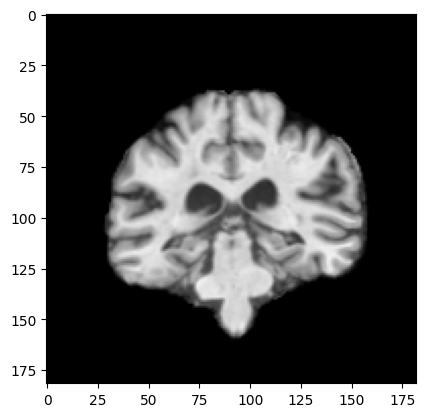

In [7]:
## image 예시
img_path = base_path + '/Mild AD/002_S_0729_110816/plane0.png'
# plan0~29
print(img_path)

image = Image.open(img_path)
print(image)

img = cv2.imread(img_path)
plt.imshow(img)
# size=182x182

## dataset

In [8]:
# label list
dir_list = ['Mild AD', 'Normal']

get_idx_lable = {}
get_label_idx = []
for idx, lable in enumerate(dir_list):
    get_idx_lable[lable] = idx
    get_label_idx.append(lable)
print(get_idx_lable)
print(get_label_idx)

{'Mild AD': 0, 'Normal': 1}
['Mild AD', 'Normal']


In [9]:
# datalist, label
get_all_datalist, get_all_label = [], []
for get_dir in dir_list:
    get_dir_path = os.path.join(base_path, get_dir)
    get_subject_list = os.listdir(get_dir_path)
    for get_subject in get_subject_list:
        get_subject_path = os.path.join(get_dir_path, get_subject)
        get_file_list = os.listdir(get_subject_path)
        for get_file in get_file_list:
          if get_file.endswith('.png'):
            get_file_path = os.path.join(get_subject_path, get_file)
            get_all_datalist.append(get_file_path)
            lable = get_file_path.split("/")[-3]
            get_all_label.append(lable)

print(get_all_datalist)
print(set(get_all_label))

['/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane9.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane26.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane16.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane19.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane21.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane17.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane27.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane0.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane3.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/002_S_5018_130211/plane15.png', '/home/medicalteam/바탕화면/민지/project/Real_data/datasets/Mild AD/

In [10]:
# final_df
final_df = pd.DataFrame({
    'data_path': get_all_datalist,
    'label': get_all_label
})

print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19230 entries, 0 to 19229
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  19230 non-null  object
 1   label      19230 non-null  object
dtypes: object(2)
memory usage: 300.6+ KB
None
                                           data_path    label
0  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
1  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
2  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
3  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD
4  /home/medicalteam/바탕화면/민지/project/Real_data/da...  Mild AD


In [11]:
# label_object to int
final_df['label'] = final_df['label'].map(get_idx_lable)

print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19230 entries, 0 to 19229
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  19230 non-null  object
 1   label      19230 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 300.6+ KB
None
                                           data_path  label
0  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
1  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
2  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
3  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0
4  /home/medicalteam/바탕화면/민지/project/Real_data/da...      0


In [12]:
# data split
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(final_df['data_path'], final_df['label'], test_size=0.2, random_state=42)
train_data, test_data, train_labels, test_labels = \
    train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
"""
train_data, train_labels 0.6
valid_data, valid_labels 0.2
test_data, test_labels 0.2
"""
print(train_data.shape, train_labels.shape)
print(valid_data.shape, valid_labels.shape)
print(test_data.shape, test_labels.shape)

(12307,) (12307,)
(3846,) (3846,)
(3077,) (3077,)


In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data.values.tolist()  # list 형태로 입력
        self.labels = labels.values.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]  # Get image path from the dataframe
        label = self.labels[idx]     # Get label from the dataframe

        # Load image
        image = Image.open(img_path)
        # print('image info before transform: %s' %(image))

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            # print(f'image info after transform: {image.shape}')

        return image, label

In [14]:
# Define batch_size
batch_size = 30

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),           # Convert images to tensors
    # transforms.RandomRotation(10),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    # transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize pixel values
    # transforms.ToPILImage(mode=None)
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),           # Convert images to tensors
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    # transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize pixel values
    # transforms.ToPILImage(mode=None)
])

# Create dataset instances
train_dataset = CustomDataset(train_data, train_labels, transform=transform_train)
valid_dataset = CustomDataset(valid_data, valid_labels, transform=transform)
test_dataset = CustomDataset(test_data, test_labels, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [15]:
# dataset 확인
print('dataset len: %d' %(train_dataset.__len__()))
train_dataset.__getitem__(0)

dataset len: 12307


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 1)

In [16]:
# dataloader 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0])


In [17]:
# # DataLoader가 올바르게 되었는지 검사
# for batch in train_loader:
#   break

tensor(0)


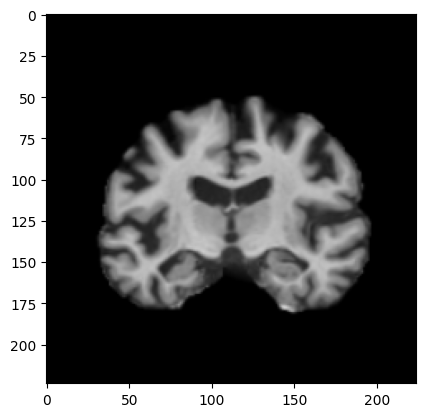

tensor(1)


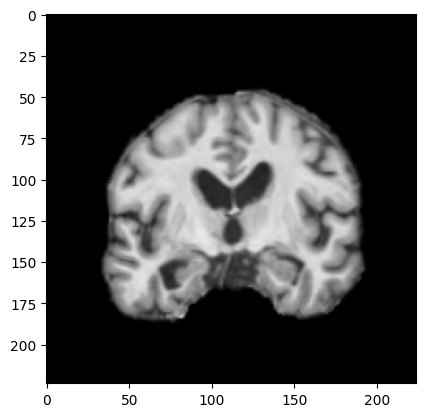

tensor(1)


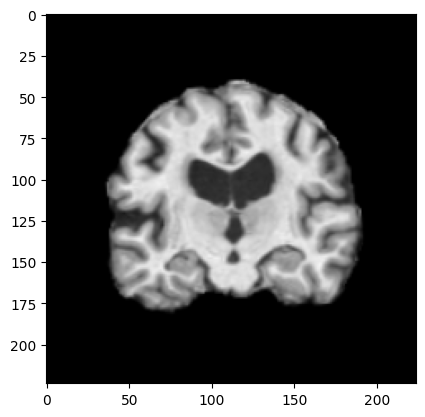

tensor(1)


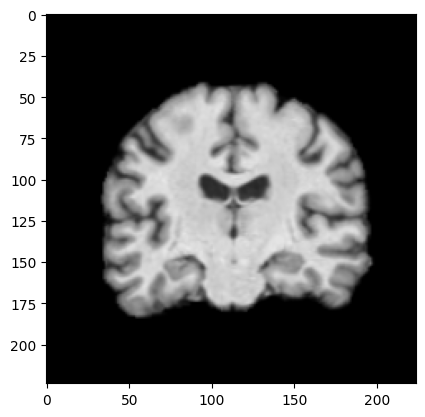

tensor(1)


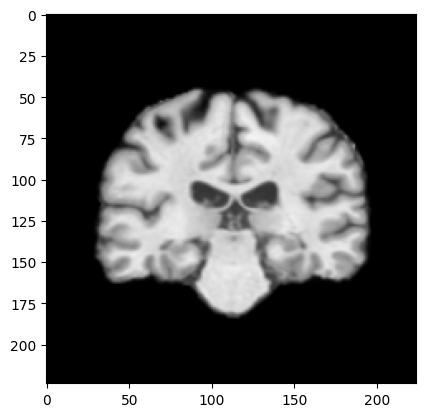

tensor(1)


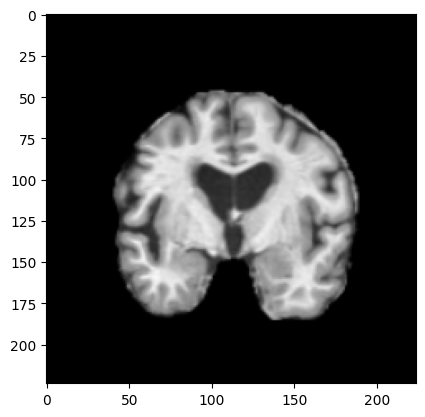

tensor(1)


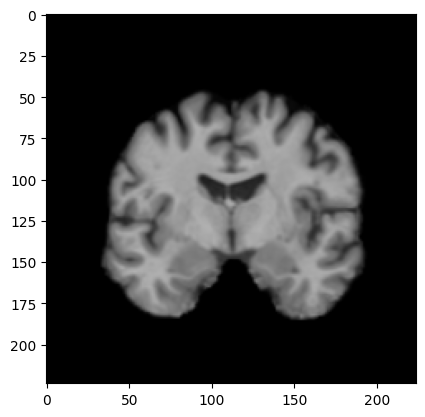

tensor(1)


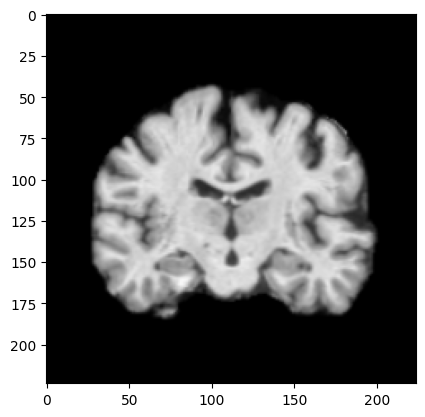

tensor(1)


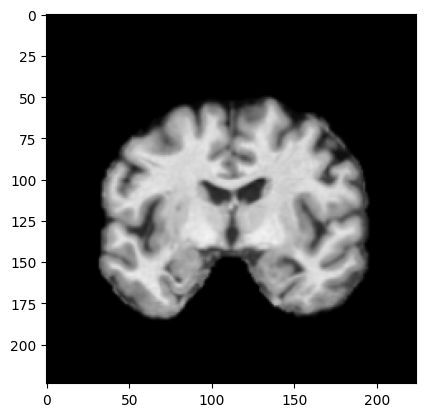

tensor(0)


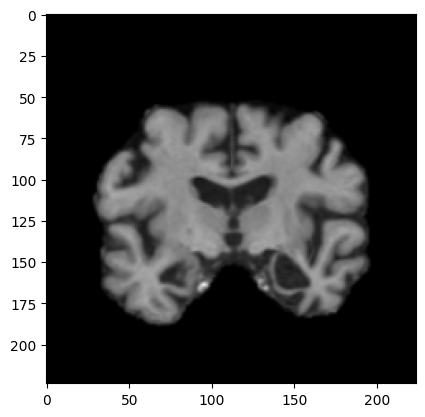

tensor(0)


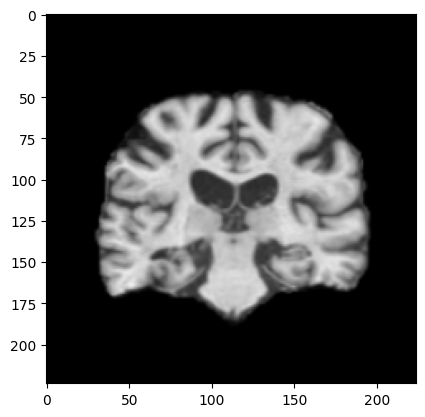

tensor(1)


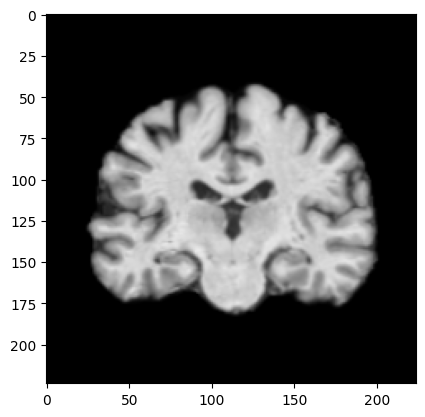

tensor(1)


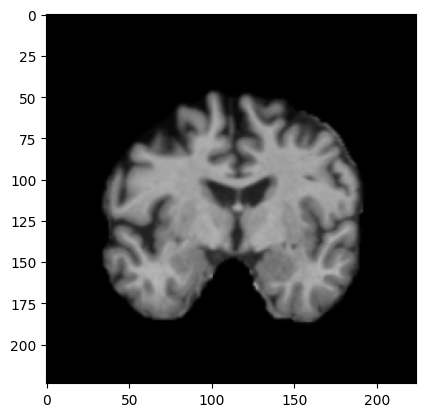

tensor(0)


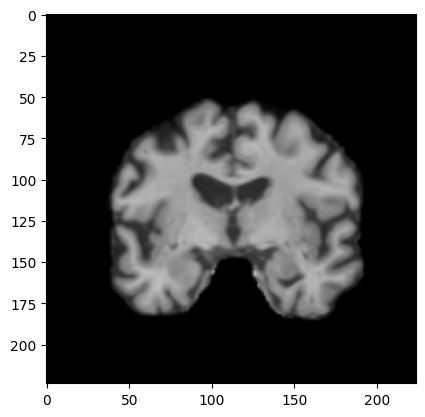

tensor(1)


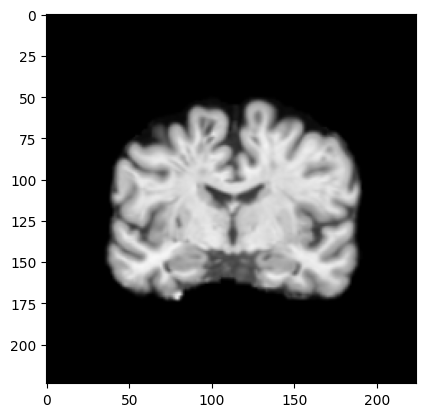

tensor(1)


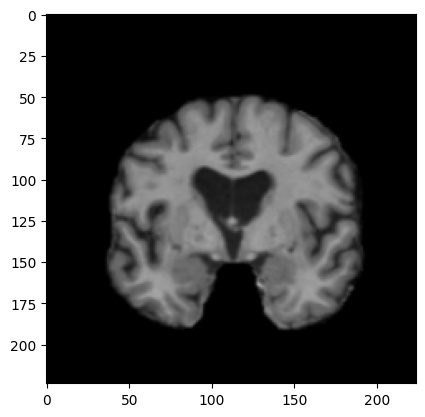

tensor(0)


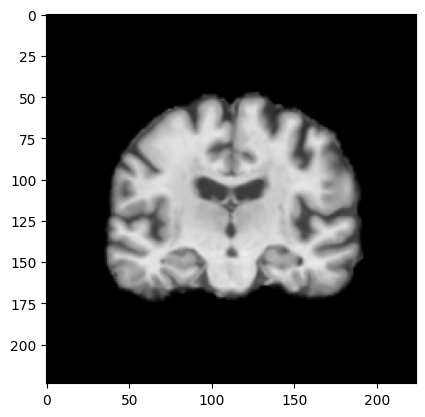

tensor(1)


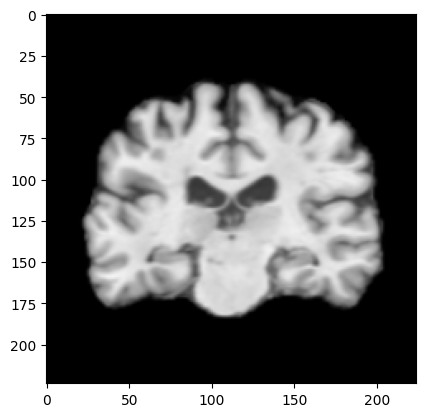

tensor(1)


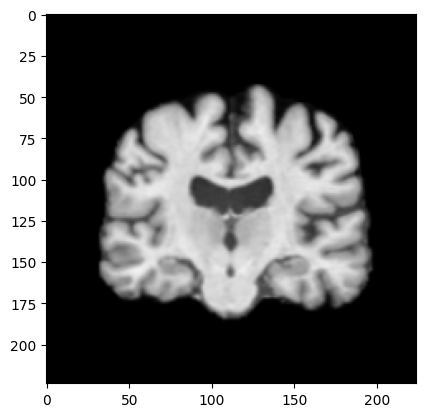

tensor(1)


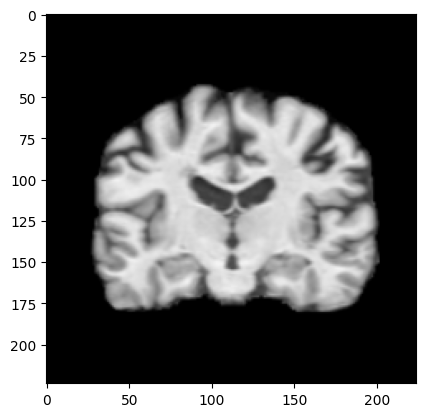

tensor(1)


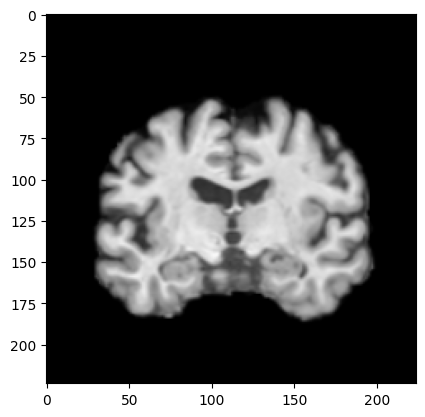

tensor(1)


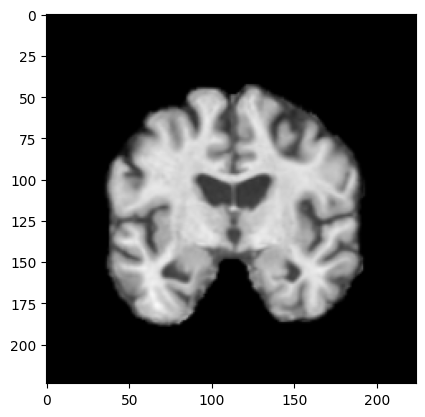

tensor(0)


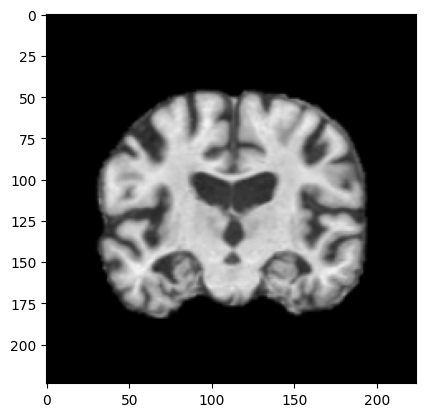

tensor(1)


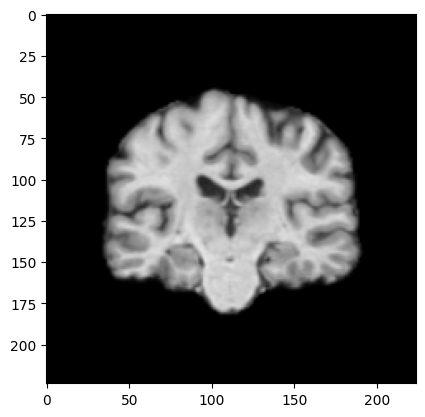

tensor(1)


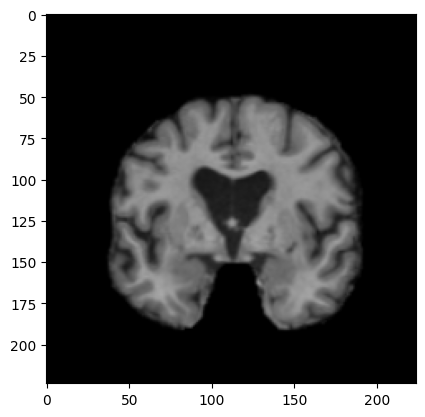

tensor(1)


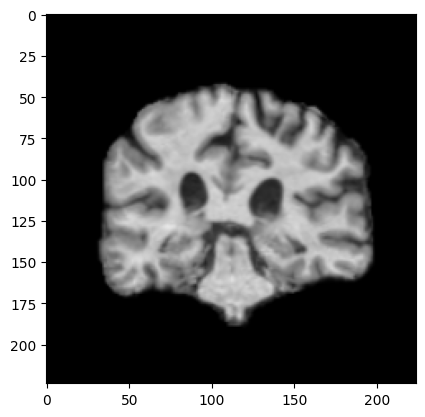

tensor(1)


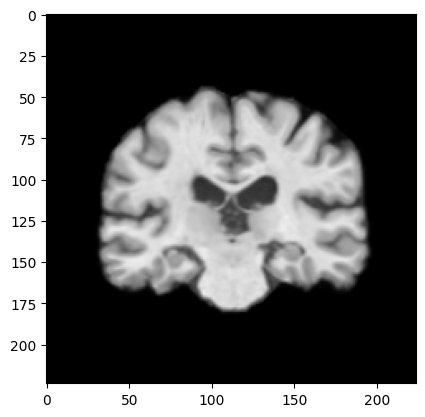

tensor(0)


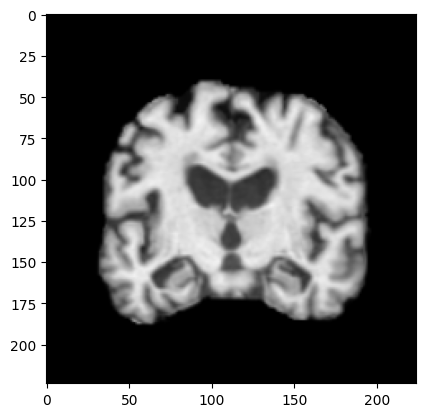

tensor(0)


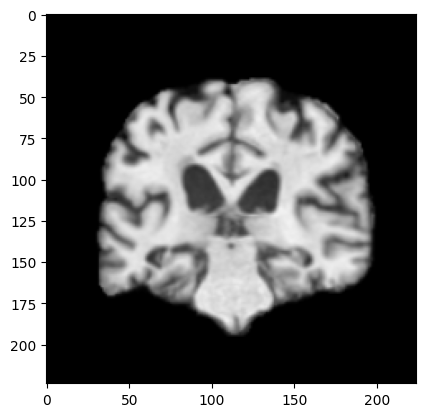

tensor(1)


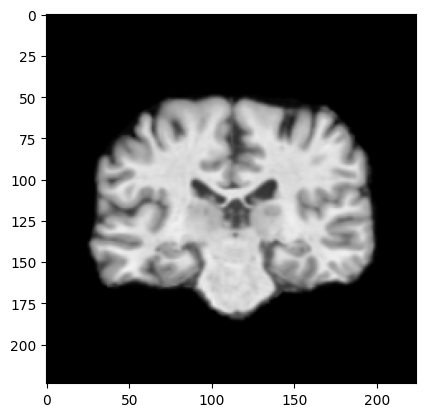

In [18]:
# 데이터 확인
def custom_imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()

tensor = []
def process():
  for batch_idx, (images, labels) in enumerate(train_loader):
    for i in range (30):
      print(labels[i])
      tensor.append(images[i])
      custom_imshow(images[i])
    if batch_idx == 0:
      break

process()

In [19]:
for i in range(224):
  print(tensor[0][0][i])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0.,

In [20]:
# 레이블 인덱스 별 레이블 지정
labels = get_idx_lable
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

print('인덱스 별 레이블: ', id2label)
print('레이블 별 인덱스: ', label2id)

인덱스 별 레이블:  {0: 'Mild AD', 1: 'Normal'}
레이블 별 인덱스:  {'Mild AD': 0, 'Normal': 1}


In [21]:
## Tensorflow ver.
# train_idg = ImageDataGenerator(rescale=1./255,
#                                rotation_range=0.1,
#                                width_shift_range=0.1,
#                                height_shift_range=0.1,
#                                zoom_range=0.1,
#                                horizontal_flip=False,
#                                vertical_flip=False)

# valid_idg = ImageDataGenerator(rescale=1./255)
# test_idg = ImageDataGenerator(rescale=1./255)

In [22]:
## Tensorflow ver.
# train_generator = train_idg.flow_from_dataframe(dataframe=train_df,
#                                                 directory=None,
#                                                 x_col="data",
#                                                 y_col="label",
#                                                 class_mode="categorical",
#                                                 target_size=(224,224),
#                                                 batch_size=batch_size)

# valid_generator = test_idg.flow_from_dataframe(dataframe=valid_df,
#                                               directory=None,
#                                               x_col="data",
#                                               y_col="label",
#                                               class_mode="categorical",
#                                               target_size=(224,224),
#                                               batch_size=batch_size)

# test_generator = test_idg.flow_from_dataframe(dataframe=test_df,
#                                               directory=None,
#                                               x_col="data",
#                                               y_col="label",
#                                               class_mode="categorical",
#                                               target_size=(224,224),
#                                               batch_size=batch_size)

In [23]:
## Tensorflow ver.
# # 데이터셋에 저장된 이미지를 출력하는 함수
# # 이미지 확인을 위해 사용한다.
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 5, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip( images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

In [24]:
## Tensorflow ver.
# # generator 예시
# augmented_images = [train_generator[0][0][0] for i in range(5)]
# plotImages(augmented_images)

## model

In [25]:
# Initialize Transformer model and image processor

# model_name = "google/vit-base-patch16-224-in21k"
model_name = "DHEIVER/Alzheimer-MRI"
processor = AutoImageProcessor.from_pretrained(model_name, label2id=label2id, id2label=id2label) # 이미지를 patch로 잘라줌
# pretrained_model = AutoModelForImageClassification.from_pretrained(model_name)
configuration = AutoConfig.from_pretrained(model_name)
configuration.num_labels = 2

# pretrained_model = SwinForImageClassification.from_pretrained(
#     model_name,
#     num_labels=2,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes = True)
pretrained_model = ViTForImageClassification(configuration)

In [26]:
# 모듈 이름 확인
for name, param in pretrained_model.base_model.named_parameters():
    if 'layernorm' in name:
      print(name)
    print(name, param.shape)

embeddings.cls_token torch.Size([1, 1, 768])
embeddings.position_embeddings torch.Size([1, 197, 768])
embeddings.patch_embeddings.projection.weight torch.Size([768, 3, 16, 16])
embeddings.patch_embeddings.projection.bias torch.Size([768])
encoder.layer.0.attention.attention.query.weight torch.Size([768, 768])
encoder.layer.0.attention.attention.query.bias torch.Size([768])
encoder.layer.0.attention.attention.key.weight torch.Size([768, 768])
encoder.layer.0.attention.attention.key.bias torch.Size([768])
encoder.layer.0.attention.attention.value.weight torch.Size([768, 768])
encoder.layer.0.attention.attention.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.intermediate.dense.bias torch.Size([3072])
encoder.layer.0.output.dense.weight torch.Size([768, 3072])
encoder.layer.0.output.dense.bias torc

In [27]:
# for name, param in pretrained_model.base_model.named_parameters():
#     param.requires_grad = False
#     if 'layernorm' in name: # 마지막 layer만 수정
#       param.requires_grad = True

In [28]:
# # parameter freeze
# # pretrained model의 웨이트 고정 -> 안하면 오버피팅 가능성있음!
# # (1) 한거 안한거 비교해보기
# for param in pretrained_model.base_model.parameters():
#     param.requires_grad = False

In [29]:
# model 확인
print(pretrained_model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [30]:
class fine_tuned_model(nn.Module):
  def __init__(self, pretrained_model, get_label_idx):
    super(fine_tuned_model, self).__init__()
    self.label_num = len(get_label_idx)

    self.pretrained_model = pretrained_model
    # self.dense = nn.Sequential(
    #         # nn.Linear(in_features=2, out_features=4, bias=True),
    #         # nn.Linear(in_features=4, out_features=16, bias=True),
    #         # nn.Linear(in_features=16, out_features=self.label_num, bias=True)
    #         nn.Linear(in_features=2, out_features=self.label_num, bias=True)
    #     )

  def forward(self, **inputs):
    outputs = self.pretrained_model(**inputs)
    logits = outputs.logits
    # output = self.dense(logits)
    output = logits

    return output

# class ClassificationModel(nn.Module):
#     def __init__(self, pretrained_model='bert-base-uncased', num_labels=2):
#         super(ClassificationModel, self).__init__()
#         self.bert = BertModel.from_pretrained(pretrained_model)
#         self.linear = nn.Sequential(nn.Linear(768, 128),
#                                     nn.Tanh(),
#                                     nn.Linear(128, num_labels))

#     def forward(self, x):
#         all_hidden, pooler = self.bert(**x)
#         pooled_output = torch.mean(all_hidden, 1)
#         predict = self.linear(pooled_output)
#         return predict

In [31]:
# model 정의
model = fine_tuned_model(pretrained_model, get_label_idx)
# model = pretrained_model

In [32]:
# # model 확인
print("\n\n------Model------")
print(model)



------Model------
fine_tuned_model(
  (pretrained_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
          

In [33]:
# %pip install wandb

In [34]:
import wandb
wandb.login
wandb.init(project="Memoria", entity='sasmco12', name='ViTtransformer_MRI2')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sasmco12. Use `wandb login --relogin` to force relogin


In [45]:
num_epochs = 5

In [36]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [37]:
# init config setting
wandb.config = {
  "learning_rate": 1e-4,
  "epochs": num_epochs,
  "batch_size": batch_size
}

In [38]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)

cpu


In [46]:
# # 모델 직접 저장 예시
# model = torch.load('swintransformer.pt')

# 딕셔너리 형태 저장 예시
finalepoch = 15
ptpath = f'/home/medicalteam/바탕화면/민지/project/ViTTransformer_{finalepoch}.pt'
checkpoint = torch.load(ptpath)
model.load_state_dict(checkpoint) # state_dict 형태로 저장된 파라미터 불러오기

<All keys matched successfully>

In [47]:
model.to(DEVICE)

save_interval = 1

model.train()
train_losses = []
valid_losses = []
step = 0

# Training loop
for epoch in range(num_epochs):
    losses = []
    print("\n Epoch {}/{}".format(epoch+1, num_epochs))
    for inputs, labels in tqdm(train_loader):
      inputs, labels = inputs, labels.to(DEVICE)
      optimizer.zero_grad()
      inputs = processor(images=inputs, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)
        # pt: tensor로 반환
        # padding: 해당 batch가 가질 수 있는 가장 긴 길이로 padding
      outputs = model(**inputs)
      # logits = outputs.logits
      # # model predicts one of the classes
      # predictions = torch.argmax(logits, dim=-1)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()

      step += 1

      # 평균 손실 출력 및 분류
      if (step + 1) % 1 == 0:
        print("Step {}: batch Mean Loss: {}".format(step, loss))
        wandb.log({'train_loss': loss})

    print("Epoch {}/{} This Loss is : {}".format(epoch+1, num_epochs, np.mean(losses)))
    train_losses.append(np.mean(losses))

    if (epoch + 1) % save_interval == 0:
      checkpoint_path = f'/home/medicalteam/바탕화면/민지/project/ViTTransformer_{epoch+16}.pt'
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Saved model checkpoint for epoch {epoch+1}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs, labels.to(DEVICE)
            inputs = processor(images=inputs, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)
            outputs = model(**inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
            wandb.log({'valid_loss': val_loss})

    print(f"Epoch {epoch + 1}: Train Loss {np.mean(losses)}, Validation Loss {np.mean(val_losses)}")


 Epoch 1/5


  0%|          | 0/411 [00:00<?, ?it/s]

Step 1: batch Mean Loss: 0.042313121259212494
Step 2: batch Mean Loss: 0.0762132927775383
Step 3: batch Mean Loss: 0.010547252371907234
Step 4: batch Mean Loss: 0.1290775090456009
Step 5: batch Mean Loss: 0.03512299805879593
Step 6: batch Mean Loss: 0.038312043994665146
Step 7: batch Mean Loss: 0.05101204663515091
Step 8: batch Mean Loss: 0.06570645421743393
Step 9: batch Mean Loss: 0.09379927814006805
Step 10: batch Mean Loss: 0.15022538602352142
Step 11: batch Mean Loss: 0.053006164729595184
Step 12: batch Mean Loss: 0.018404657021164894
Step 13: batch Mean Loss: 0.07337095588445663
Step 14: batch Mean Loss: 0.08046437799930573
Step 15: batch Mean Loss: 0.15278495848178864
Step 16: batch Mean Loss: 0.2088504135608673
Step 17: batch Mean Loss: 0.042330630123615265
Step 18: batch Mean Loss: 0.07329952716827393
Step 19: batch Mean Loss: 0.19411157071590424
Step 20: batch Mean Loss: 0.09747720509767532
Step 21: batch Mean Loss: 0.15720824897289276
Step 22: batch Mean Loss: 0.111972942948

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.10933665528558104, Validation Loss 0.15310926652376272

 Epoch 2/5


  0%|          | 0/411 [00:00<?, ?it/s]

Step 412: batch Mean Loss: 0.065474733710289
Step 413: batch Mean Loss: 0.09191713482141495
Step 414: batch Mean Loss: 0.03624264895915985
Step 415: batch Mean Loss: 0.06536625325679779
Step 416: batch Mean Loss: 0.161911278963089
Step 417: batch Mean Loss: 0.4206240773200989
Step 418: batch Mean Loss: 0.16646909713745117
Step 419: batch Mean Loss: 0.04305088147521019
Step 420: batch Mean Loss: 0.0937267616391182
Step 421: batch Mean Loss: 0.08870873600244522
Step 422: batch Mean Loss: 0.07823778688907623
Step 423: batch Mean Loss: 0.07585349678993225
Step 424: batch Mean Loss: 0.12609533965587616
Step 425: batch Mean Loss: 0.1681351661682129
Step 426: batch Mean Loss: 0.27008381485939026
Step 427: batch Mean Loss: 0.08774714916944504
Step 428: batch Mean Loss: 0.0577087327837944
Step 429: batch Mean Loss: 0.06576807796955109
Step 430: batch Mean Loss: 0.13854598999023438
Step 431: batch Mean Loss: 0.06853010505437851
Step 432: batch Mean Loss: 0.06280425190925598
Step 433: batch Mean 

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.09770422182193167, Validation Loss 0.15855372120994468

 Epoch 3/5


  0%|          | 0/411 [00:00<?, ?it/s]

Step 823: batch Mean Loss: 0.03878640756011009
Step 824: batch Mean Loss: 0.09892923384904861
Step 825: batch Mean Loss: 0.03577348217368126
Step 826: batch Mean Loss: 0.22280433773994446
Step 827: batch Mean Loss: 0.011926401406526566
Step 828: batch Mean Loss: 0.11658884584903717
Step 829: batch Mean Loss: 0.21965262293815613
Step 830: batch Mean Loss: 0.07814133912324905
Step 831: batch Mean Loss: 0.015901843085885048
Step 832: batch Mean Loss: 0.08857937902212143
Step 833: batch Mean Loss: 0.15441323816776276
Step 834: batch Mean Loss: 0.032317887991666794
Step 835: batch Mean Loss: 0.04381315037608147
Step 836: batch Mean Loss: 0.16031795740127563
Step 837: batch Mean Loss: 0.16802051663398743
Step 838: batch Mean Loss: 0.1657586693763733
Step 839: batch Mean Loss: 0.0777372494339943
Step 840: batch Mean Loss: 0.08351843059062958
Step 841: batch Mean Loss: 0.0632687583565712
Step 842: batch Mean Loss: 0.20599673688411713
Step 843: batch Mean Loss: 0.15349839627742767
Step 844: bat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 1117: batch Mean Loss: 0.03926175832748413
Step 1118: batch Mean Loss: 0.10413500666618347
Step 1119: batch Mean Loss: 0.016953548416495323
Step 1120: batch Mean Loss: 0.03456271067261696
Step 1121: batch Mean Loss: 0.012567603960633278
Step 1122: batch Mean Loss: 0.032290980219841
Step 1123: batch Mean Loss: 0.11766750365495682
Step 1124: batch Mean Loss: 0.02411729097366333
Step 1125: batch Mean Loss: 0.14948353171348572
Step 1126: batch Mean Loss: 0.06778310239315033
Step 1127: batch Mean Loss: 0.0932527482509613
Step 1128: batch Mean Loss: 0.060068510472774506
Step 1129: batch Mean Loss: 0.04663443937897682
Step 1130: batch Mean Loss: 0.009544420056045055
Step 1131: batch Mean Loss: 0.11642874032258987
Step 1132: batch Mean Loss: 0.0071656894870102406
Step 1133: batch Mean Loss: 0.024384193122386932
Step 1134: batch Mean Loss: 0.07844309508800507
Step 1135: batch Mean Loss: 0.027882222086191177
Step 1136: batch Mean Loss: 0.18356555700302124
Step 1137: batch Mean Loss: 0.01962

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch 3: Train Loss 0.09485260215803183, Validation Loss 0.13404871276471503

 Epoch 4/5


  0%|          | 0/411 [00:00<?, ?it/s]

Step 1234: batch Mean Loss: 0.08601723611354828
Step 1235: batch Mean Loss: 0.04806610196828842
Step 1236: batch Mean Loss: 0.05411291867494583
Step 1237: batch Mean Loss: 0.04801175370812416
Step 1238: batch Mean Loss: 0.11731664836406708
Step 1239: batch Mean Loss: 0.026516634970903397
Step 1240: batch Mean Loss: 0.010262797586619854
Step 1241: batch Mean Loss: 0.052030403167009354
Step 1242: batch Mean Loss: 0.11005904525518417
Step 1243: batch Mean Loss: 0.0701444074511528
Step 1244: batch Mean Loss: 0.05908045917749405
Step 1245: batch Mean Loss: 0.16326220333576202
Step 1246: batch Mean Loss: 0.30343005061149597
Step 1247: batch Mean Loss: 0.011899842880666256
Step 1248: batch Mean Loss: 0.2982790768146515
Step 1249: batch Mean Loss: 0.026923449710011482
Step 1250: batch Mean Loss: 0.03382212296128273
Step 1251: batch Mean Loss: 0.08662308007478714
Step 1252: batch Mean Loss: 0.0919092446565628
Step 1253: batch Mean Loss: 0.05603896453976631
Step 1254: batch Mean Loss: 0.12818400

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch 4: Train Loss 0.08214696869594011, Validation Loss 0.14963830063523825

 Epoch 5/5


  0%|          | 0/411 [00:00<?, ?it/s]

Step 1645: batch Mean Loss: 0.11365555226802826
Step 1646: batch Mean Loss: 0.07329507917165756
Step 1647: batch Mean Loss: 0.06793580204248428
Step 1648: batch Mean Loss: 0.020450059324502945
Step 1649: batch Mean Loss: 0.014243898913264275
Step 1650: batch Mean Loss: 0.022675324231386185
Step 1651: batch Mean Loss: 0.11688613891601562
Step 1652: batch Mean Loss: 0.12387457489967346
Step 1653: batch Mean Loss: 0.11406358331441879
Step 1654: batch Mean Loss: 0.04750942438840866
Step 1655: batch Mean Loss: 0.1135491207242012
Step 1656: batch Mean Loss: 0.02444400079548359
Step 1657: batch Mean Loss: 0.39968398213386536
Step 1658: batch Mean Loss: 0.192988321185112
Step 1659: batch Mean Loss: 0.07783474773168564
Step 1660: batch Mean Loss: 0.08416358381509781
Step 1661: batch Mean Loss: 0.028596611693501472
Step 1662: batch Mean Loss: 0.043354932218790054
Step 1663: batch Mean Loss: 0.06860900670289993
Step 1664: batch Mean Loss: 0.029374830424785614
Step 1665: batch Mean Loss: 0.1005555

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch 5: Train Loss 0.08314487457682136, Validation Loss 0.12505159254886153


NameError: name 'val_losses' is not defined

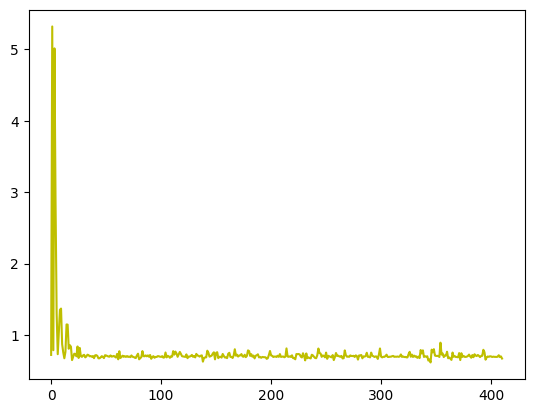

In [43]:
# visualization
fig, loss_ax = plt.subplots()

loss_ax.plot(range(len(losses)), losses, 'y', label = 'train loss')
loss_ax.plot(range(len(val_losses)), val_losses, 'r', label = 'val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('input')
# loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
#정확도 및 f1값 저장
from sklearn.metrics import accuracy_score, recall_score, f1_score
accuracy = 0
f1 = 0

In [39]:
# # 모델 직접 저장 예시
# model = torch.load('swintransformer.pt')

# 딕셔너리 형태 저장 예시
finalepoch = 4
ptpath = f'/home/medicalteam/바탕화면/민지/project/ViTTransformer_{finalepoch}.pt'
checkpoint = torch.load(ptpath)
model.load_state_dict(checkpoint) # state_dict 형태로 저장된 파라미터 불러오기

<All keys matched successfully>

In [40]:
# Validation
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc

model.to(DEVICE)
model.eval()

val_labels = []
val_predictions = []
    
with torch.no_grad():
    val_losses = []
    for inputs, labels in tqdm(valid_loader):
        inputs, labels = inputs, labels.to(DEVICE)
        inputs = processor(images=inputs, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)
        outputs = model(**inputs)
        val_loss = criterion(outputs, labels)
        val_losses.append(val_loss.item())
        predictions = torch.argmax(outputs, dim=-1)
    
        val_labels.extend(labels.to(torch.device('cpu')))
        val_predictions.extend(predictions.to(torch.device('cpu')))
    
    # 손실과 정확도 출력
    val_accuracy = accuracy_score(val_labels, val_predictions)
    confusion = confusion_matrix(val_labels, val_predictions)
    specififcity = recall_score(val_labels, val_predictions, pos_label=0)
    sensitivity = recall_score(val_labels, val_predictions, pos_label=1)                   
#     specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
#     sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(val_labels, val_predictions)
        
    print(f"Validation Loss {np.mean(val_losses)}")

  0%|          | 0/129 [00:00<?, ?it/s]

Validation Loss 0.47879886488581813


In [41]:
print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specififcity, sensitivity, auc_score))

Validation Accuracy: 0.782, Specificity: 0.714, Sensitivity: 0.851, AUC: 0.783


In [ ]:
# Evaluation on test set
# 각 분류(class)에 대한 예측값 계산을 위해 준비
# correct_pred = {classname: 0 for classname in get_all_label}
# total_pred = {classname: 0 for classname in get_all_label}

model.to(DEVICE)
model.eval()

test_labels = []
test_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs, labels.to(DEVICE)
        inputs = processor(images=inputs, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print("This Loss is : {}".format(loss))
        predictions = torch.argmax(outputs, dim=-1)
        print("label: {}, prediction: {}".format(labels, predictions))
        
    # 손실과 정확도 출력
    mean_train_loss = epoch_train_loss_avg.result()
    mean_validation_loss = np.mean(epoch_validation_losses)
    val_accuracy = accuracy_score(epoch_validation_labels, epoch_validation_predictions)
    confusion = confusion_matrix(epoch_validation_labels, epoch_validation_predictions)
    specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
    sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(epoch_validation_labels, epoch_validation_predictions)

#     print("Epoch {}: Train Loss {:.3f}, Validation Loss {:.3f}".format(epoch+1, mean_train_loss, mean_validation_loss))
    print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specificity, sensitivity, auc_score))

        #모델이 GPU에서 작동하고 데이터가 GPU에 있기 때문에 CPU로 옮기는 과정이 필요함
#         acc = accuracy_score(labels.to(torch.device('cpu')), predictions.to(torch.device('cpu')))
#         accuracy += acc
        # f = f1_score(labels.to(torch.device('cpu')), predictions.to(torch.device('cpu')))
        # f1 += f

# accuracy /= len(test_loader)
# f1 /= len(test_loader)

#정확도와 f1출력
# print("Accuracy: ", accuracy)
# print("Accuracy: ", accuracy, "\n", "F1_Score: ", f1)


#         for label, prediction in zip(labels, outputs):
#             if label == prediction:
#                 correct_pred[get_all_label[label]] += 1
#             total_pred[get_all_label[label]] += 1

# # 각 분류별 정확도(accuracy)를 출력합니다
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()

# print("Predicted class:", model.config.id2label[predicted_class_idx])

# Attention map visualize

tensor(0)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


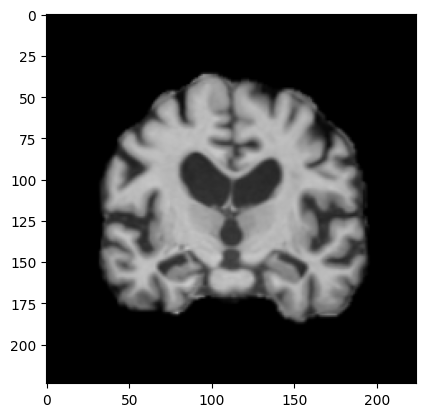

In [45]:
# test_tensor
def custom_imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()

test_tensor = []
def process():
  for batch_idx, (images, labels) in enumerate(test_loader):
    for i in range (30):
        if labels[i] == 0:
            print(labels[i])
            test_tensor.append(images[i])
            print(images[i])
            custom_imshow(images[i])
            break;
#       if i == 0:
#         break
    if batch_idx == 0:
      break

process()

# processor
test_tensor = processor(images=test_tensor, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)

In [46]:
def rollout(attentions, discard_ratio, head_fusion):
    # [2, 12, 197, 197]
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
#             print(attention.shape) #torch.Size([batch_num, 12, 197, 197])
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

#             print(attention_heads_fused.shape) #torch.Size([batch_num, 197, 197])

            # Drop the lowest attentions, but
            # don't drop the class token
#             print('size(0)', attention_heads_fused.size(0)) # batch_num
#             print('size(1)', attention_heads_fused.size(-1)) # 197
            attention_heads_fused = attention_heads_fused[0] # batch 첫번째만 선택
            attention_heads_fused = torch.unsqueeze(attention_heads_fused, dim=0)
#             print(attention_heads_fused.shape) #torch.Size([1, 197, 197])

            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
#             print(flat.shape) # torch.Size([1, 38809])
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)

    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attention.dropout', head_fusion="mean", discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, **input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(**input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [47]:
# # 모델 직접 저장 예시
# model = torch.load('swintransformer.pt')

# 딕셔너리 형태 저장 예시
finalepoch = 7
ptpath = f'/home/medicalteam/바탕화면/민지/project/ViTTransformer_{finalepoch}.pt'
checkpoint = torch.load(ptpath)
model.load_state_dict(checkpoint) # state_dict 형태로 저장된 파라미터 불러오기

<All keys matched successfully>

In [48]:
# attention map 뽑기
imagename = 'test'
attention_rollout = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='mean')
mask = attention_rollout(**test_tensor) # (14,14)
name = "/home/medicalteam/바탕화면/민지/project/attention_rollout_{}.png".format(imagename)

(14, 14)


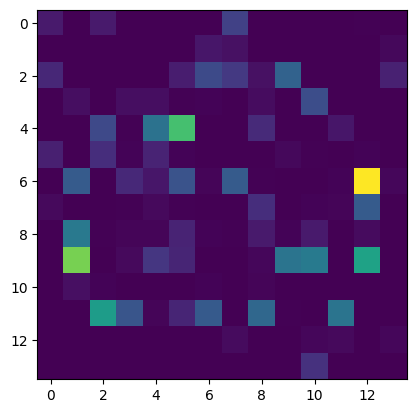

In [49]:
print(mask.shape)
plt.imshow(mask)

In [50]:
# # attention layer 확인
# attention_layer_name='attention'

# for name, module in model.named_modules():
#   if attention_layer_name in name:
#       print(name)

In [51]:
# def show_mask_on_image(img, mask):
#     img = np.float32(img) / 255
#     heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
#     heatmap = np.float32(heatmap) / 255
#     cam = heatmap + np.float32(img)
#     cam = cam / np.max(cam)
#     return np.uint8(img), np.uint8(255 * mask), np.uint8(255 * cam)

In [52]:
# # np_img = np.array(img)[:, :, ::-1]
# mask = cv2.resize(mask, (test_tensor[0].shape[1], test_tensor[0].shape[0]))
# # mask = show_mask_on_image(np_img, mask)
# # plt.imshow("Input Image", np_img)
# # plt.imshow(name, mask)
# # plt.imwrite("input.png", np_img)
# # plt.imwrite(name, mask)
# # plt.waitKey(-1)

In [63]:
img = test_tensor['pixel_values']
img = torch.squeeze(img)
img = np.transpose(img, (1,2,0))
# img check
print(img.shape)

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
print(mask.shape)

heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
heatmap = heatmap / np.max(heatmap)
heatmap = np.uint8(255*heatmap)
print(heatmap.shape)

img_cam = np.float32(img) / 255
cam = heatmap + np.float32(img_cam)
cam = cam / np.max(cam)
cam = np.uint8(255*cam)
print(cam.shape)

torch.Size([224, 224, 3])
(224, 224)
(224, 224, 3)
(224, 224, 3)


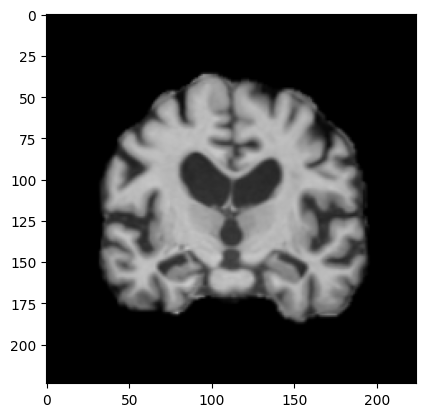

In [64]:
plt.imshow(img)

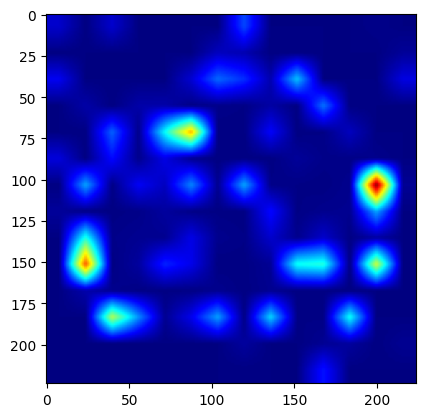

In [65]:
plt.imshow(heatmap)

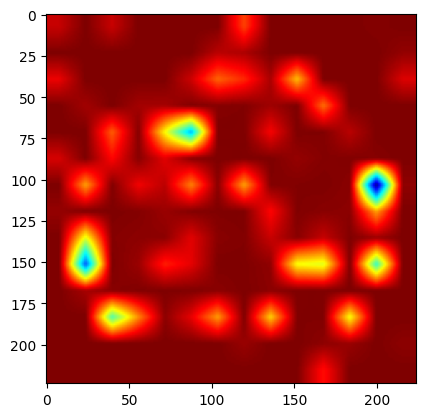

In [57]:
plt.imshow(cam)

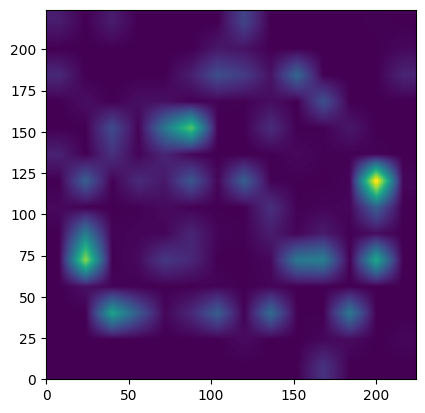

In [63]:
plt.imshow(mask, extent=[0, 224, 0, 224])

In [224]:
heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
heatmap.shape

(224, 224, 3)

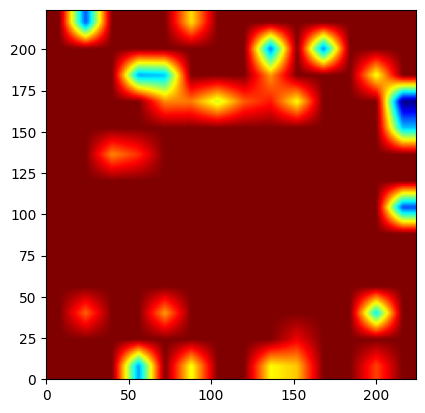

In [225]:
plt.imshow(heatmap, extent=[0, 224, 0, 224])

In [145]:
#----------------------------------------------------------------------------------#

In [ ]:
# (2) AutoImageClassification
test_tensor1 = processor(images=test_tensor, return_tensors="pt", padding=True, do_normalize=False).to(DEVICE)
test_tensor2 = processor(images=test_tensor, return_tensors="pt", padding=True, do_resize=False, do_rescale=False, do_normalize=False).to(DEVICE)

In [ ]:
test_tensor2

{'pixel_values': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

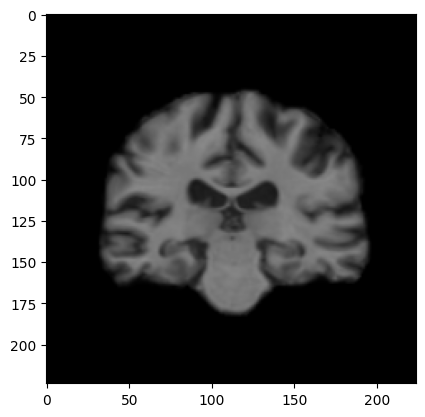

In [ ]:
test_tensor2.to(torch.device('cpu'))
custom_imshow(test_tensor2['pixel_values'][0])

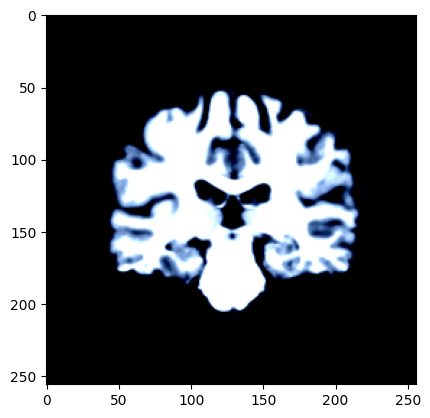

In [ ]:
custom_imshow(test_tensor['pixel_values'][1])

In [ ]:
test_tensor

{'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1

In [ ]:
#----------------------------------------------------------------------------------#

In [ ]:
# # Initialize Swin Transformer model and image processor
# model_name = "microsoft/swinv2-base-patch4-window16-256"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForImageClassification.from_pretrained(model_name)

# # model layer
# vit = processor.vit(permute)[0]
# classifier = tf.keras.layers.Dense(10, name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

# # define loss
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # define metrics
# metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss=loss,
#               metrics=metrics)

In [ ]:
# if use_colab:
#     checkpoint_dir ='/content/drive/MyDrive/2023 서울AI허브/Project/train_ckpt/medical_baseline/exp1'
#     if not os.path.isdir(checkpoint_dir):
#         os.makedirs(checkpoint_dir)
# else:
#     checkpoint_dir = './train_ckpt/medical_baseline/exp1'

In [ ]:
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
#                                                      monitor='val_loss',
#                                                      restore_best_weights=True,
#                                                      verbose=1)

In [ ]:
# train_results = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_data) // batch_size,
#     validation_data=test_generator,
#     validation_steps=len(test_data) // batch_size,
#     epochs=100,
#     callbacks=[early_stopping_cb]
# )

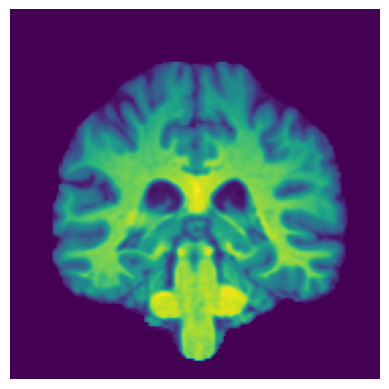

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ValueError: Unsupported number of image dimensions: 2

In [ ]:
# # Initialize Swin Transformer model and image processor
# model_name = "microsoft/swinv2-base-patch4-window16-256"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForImageClassification.from_pretrained(model_name)

# # Prepare your dataset
# train_dataset = CustomDataset(...)
# val_dataset = CustomDataset(...)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # Define loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for ccc:
#         optimizer.zero_grad()
#         inputs = processor(images=inputs, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = processor(images=inputs, return_tensors="pt", padding=True)
#             outputs = model(**inputs)
#             val_loss = criterion(outputs.logits, labels)

#     print(f"Epoch {epoch + 1}: Train Loss {loss.item()}, Validation Loss {val_loss.item()}")

# # Evaluation on test set
# test_dataset = CustomDataset(...)
# test_loader = DataLoader(test_dataset, batch_size=32)
# model.eval()
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = processor(images=inputs, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         # Compute accuracy or other evaluation metrics




# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()

# print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# pixel_values = tf.keras.layers.Input(shape=(224, 224, 3), dtype='float32')
# permute = tf.keras.layers.Permute((3, 1, 2))(pixel_values)

# # model layer
# vit = base_model.vit(permute)[0]
# classifier = tf.keras.layers.Dense(10, name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

# # define loss
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # define metrics
# metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss=loss,
#               metrics=metrics)

In [ ]:
# img_path = base_path + '/MCI/002_S_0729_060802/plane0.png'
# # url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# # image = Image.open(requests.get(img_path, stream=True).raw)
# image = Image.open(img_path)

# plt.imshow(image)
# plt.axis("off")
# plt.show()

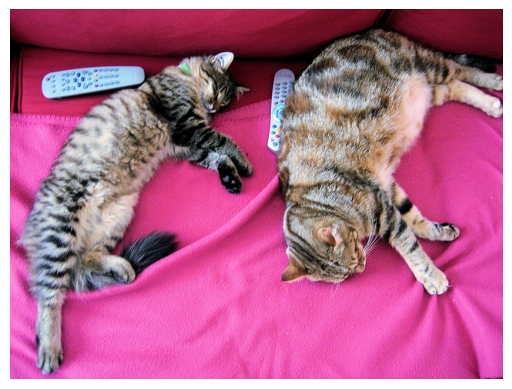

In [ ]:
# import matplotlib.pyplot as plt

# # Displaying the input image
# plt.imshow(image)
# plt.axis("off")
# plt.show()

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

# print(input)
# print(image)
# img = cv2.imread("http://images.cocodataset.org/val2017/000000039769.jpg")
# cv2_imshow(img)

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7c20a48b7a60>>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7C1F7B9C7B80>


AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_path = self.dataframe.iloc[idx, 0]  # Get image path from the dataframe
#         label = self.dataframe.iloc[idx, 1]     # Get label from the dataframe

#         # Load image
#         image = Image.open(img_path)

#         # Apply transformations if provided
#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to the desired size
#     transforms.ToTensor(),           # Convert images to tensors
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
# ])

# # Create dataset instances
# train_dataset = CustomDataset(train_df, transform=transform)
# valid_dataset = CustomDataset(valid_df, transform=transform)
# test_dataset = CustomDataset(test_df, transform=transform)

# # Create data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)